In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from snowflake.connector.pandas_tools import write_pandas
# from sqlalchemy import create_engine
import snowflake.connector

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from snowflake.connector.pandas_tools import write_pandas

d:\Users\ksbha\miniconda3\envs\footy\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (14.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


In [2]:
import snowflake.connector

In [3]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [4]:
SNOWFLAKE_USER = 'karan14'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'lv65293.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [5]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [6]:
cursor = conn.cursor()

In [7]:
def fetch_data(cursor, query):
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [8]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [9]:
team_misc = fetch_data(cursor, 'SELECT * FROM TEAM_MISC_STATS')

In [10]:
team_standard = fetch_data(cursor, 'SELECT * FROM TEAM_STANDARD_STATS')

In [11]:
team_attacking = fetch_data(cursor, 'SELECT * FROM TEAM_ATTACKING_STATS')

In [12]:
team_defending = fetch_data(cursor, 'SELECT * FROM TEAM_DEFENDING_STATS')

In [13]:
df_competitions = fetch_data(cursor, 'SELECT COMPETITION, COMPETITION_ACRONYM, SEASON FROM COMPETITIONS')

In [14]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [15]:
df_shots = fetch_data(cursor, 'SELECT * FROM SHOT_EVENTS')

In [16]:
df_players = fetch_data(cursor, 'SELECT * FROM PLAYERS')

In [17]:
team_attacking.head()

,TEAM_FBREF_ID,SEASON,COMPETITION,GOALS_SCORED,NPXG,XG,SHOTS,SHOTS_ON_TARGET,PASS_COMPLETED,PASS_ATTEMPTED,TAKEONS_ATTEMPTED,TAKEONS_COMPLETED,CROSSES_INTO_PA,FOULS_AGAINST
0,7a54bb4f,2223,FRA-Ligue 1,23,24.22,31.06,311,81,11216,15286,630,283,71,495
1,e2d8892c,2223,FRA-Ligue 1,89,81.59,86.15,562,242,23694,26476,976,454,46,416
2,d2c87802,2223,FRA-Ligue 1,52,42.79,47.35,397,149,14837,18087,916,406,38,501
3,fb08dbb3,2223,FRA-Ligue 1,44,35.32,41.40,417,132,12486,16452,655,270,94,462
4,7fdd64e0,2223,FRA-Ligue 1,45,53.34,59.52,516,165,13670,17565,800,347,87,423


In [18]:
team_attacking = team_attacking.merge(df_competitions, on=['COMPETITION','SEASON'], how='left')

team_attacking = team_attacking.merge(team_names, on='TEAM_FBREF_ID', how='left')

team_attacking = team_attacking.merge(team_standard, on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

In [19]:
team_attacking['SHOTS PER GAME'] = team_attacking['SHOTS']/team_attacking['MATCHES_PLAYED']

In [20]:
team_attacking['CONVERSION RATE (%)'] = team_attacking['GOALS_SCORED']/team_attacking['SHOTS']

In [21]:
team_attacking.head()

,TEAM_FBREF_ID,SEASON,COMPETITION,GOALS_SCORED,NPXG,XG,SHOTS,SHOTS_ON_TARGET,PASS_COMPLETED,PASS_ATTEMPTED,TAKEONS_ATTEMPTED,TAKEONS_COMPLETED,CROSSES_INTO_PA,FOULS_AGAINST,COMPETITION_ACRONYM,TEAM_NAME,TEAM_LOGO_URL,TEAM_WS_ID,MATCHES_PLAYED,TEAM_WINS,TEAM_DRAWS,TEAM_LOSSES,TEAM_PTS,TEAM_XPTS,SHOTS PER GAME,CONVERSION RATE (%)
0,7a54bb4f,2223,FRA-Ligue 1,23,24.22,31.06,311,81,11216,15286,630,283,71,495,Ligue 1,Ajaccio,https://i.imgur.com/FSm4pRb.png,610,38,7,5,26,26,33.12,8.184211,0.073955
1,e2d8892c,2223,FRA-Ligue 1,89,81.59,86.15,562,242,23694,26476,976,454,46,416,Ligue 1,Paris S-G,https://i.imgur.com/kuN3QSp.png,304,38,27,4,7,85,74.01,14.789474,0.158363
2,d2c87802,2223,FRA-Ligue 1,52,42.79,47.35,397,149,14837,18087,916,406,38,501,Ligue 1,Lorient,https://i.imgur.com/9k1Kgp6.png,146,38,15,10,13,55,42.43,10.447368,0.130982
3,fb08dbb3,2223,FRA-Ligue 1,44,35.32,41.40,417,132,12486,16452,655,270,94,462,Ligue 1,Brest,https://i.imgur.com/klKUp8n.png,2332,38,11,11,16,44,43.52,10.973684,0.105516
4,7fdd64e0,2223,FRA-Ligue 1,45,53.34,59.52,516,165,13670,17565,800,347,87,423,Ligue 1,Reims,https://i.imgur.com/xULypbI.png,950,38,12,15,11,51,55.35,13.578947,0.087209


In [22]:
attacking_efficiency_chart = team_attacking[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                                            'SHOTS PER GAME', 'CONVERSION RATE (%)']]

In [23]:
def upsert_to_snowflake(table_name, dataframe, primary_keys):
    if isinstance(primary_keys, str):
        primary_keys = [primary_keys]

    temp_table_name = f"{table_name}_TEMP"
    success, nchunks, nrows, _ = write_pandas(conn, dataframe, temp_table_name, auto_create_table=True)

    on_condition = ' AND '.join([f"{table_name}.{pk} = {temp_table_name}.{pk}" for pk in primary_keys])

    update_columns = [col for col in dataframe.columns if col not in primary_keys]
    update_sql = ', '.join([f"{table_name}.{col} = {temp_table_name}.{col}" for col in update_columns])

    merge_sql = f"""
    MERGE INTO {table_name} USING {temp_table_name}
    ON {on_condition}
    """

    if update_columns:
        merge_sql += f"""
        WHEN MATCHED THEN
            UPDATE SET
                {update_sql}
        """

    merge_sql += f"""
    WHEN NOT MATCHED THEN
        INSERT ({', '.join(dataframe.columns)})
        VALUES ({', '.join([f"{temp_table_name}.{col}" for col in dataframe.columns])})
    """

    cur.execute(merge_sql)
    cur.execute(f"DROP TABLE IF EXISTS {temp_table_name}")

    print(f"Upsert completed. {nrows} rows processed.")

In [24]:
SNOWFLAKE_SCHEMA = 'RADAR_CHARTS'

conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
    )

cur = conn.cursor()
cur.execute(f"USE WAREHOUSE {SNOWFLAKE_WAREHOUSE}")

create_schema_sql = f"CREATE SCHEMA IF NOT EXISTS {SNOWFLAKE_SCHEMA}"
cur.execute(create_schema_sql)

In [25]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_ATTACKING_EFFICIENCY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    SHOTS_PER_GAME FLOAT,
    CONVERSION_RATE FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [25]:
cur.execute(create_table_query)

In [26]:
attacking_efficiency_chart.columns = attacking_efficiency_chart.columns.str.replace(" ", "_")

In [27]:
attacking_efficiency_chart = attacking_efficiency_chart.rename({"CONVERSION_RATE_(%)":"CONVERSION_RATE"}, axis=1)

In [28]:
attacking_efficiency_chart["CONVERSION_RATE"] = attacking_efficiency_chart["CONVERSION_RATE"] * 100

In [29]:
upsert_to_snowflake("TEAM_ATTACKING_EFFICIENCY_CHART", attacking_efficiency_chart,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 292 rows processed.


In [29]:
attacking_efficiency_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_ATTACKING_EFFICIENCY_CHART')

In [30]:
attacking_efficiency_chart.rename(columns={'CONVERSION_RATE':'CONVERSION RATE (%)',
                                'SHOTS_PER_GAME':'SHOTS PER GAME'}, inplace=True)

In [31]:
def create_FM_team_scatter_chart(df, chart_name, team_name, x_axis_label, y_axis_label, img_size, x_min, x_max, y_min, y_max, bottom_left_label, 
                                 bottom_right_label, top_left_label, top_right_label, bl_color, br_color, tl_color, tr_color):
    fig = go.Figure()
    x_axis_mean_val = df[x_axis_label].mean()
    y_axis_mean_val = df[y_axis_label].mean()

    # Add the scatter plot points
    for index, row in df.iterrows():
        fig.add_trace(go.Scatter(
            x=[row[x_axis_label]],
            y=[row[y_axis_label]],
            mode='markers',
            text=row["TEAM_NAME"],
            marker=dict(
                opacity=0
            ),
            hoverinfo='text',
        ))

        # Add team logo as a layout_image
        fig.add_layout_image(
            dict(
                source=row["TEAM_LOGO_URL"],
                x=row[x_axis_label],
                y=row[y_axis_label],
                xref="x",
                yref="y",
                xanchor="center",
                yanchor="middle"
            )
        )


    # Update axes and layout as necessary
    # ...
        
    fig.update_xaxes(range=[x_min, x_max], title=x_axis_label)
    fig.update_yaxes(range=[y_min, y_max], title=y_axis_label)

    fig.add_shape(
        type='line',
        x0=x_axis_mean_val, y0=fig.layout.yaxis.range[0],  # start of the line
        x1=x_axis_mean_val, y1=fig.layout.yaxis.range[1],  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    # Add a horizontal line at the mean aerials attempted per game
    fig.add_shape(
        type='line',
        x0=fig.layout.xaxis.range[0], y0=y_axis_mean_val,  # start of the line
        x1=fig.layout.xaxis.range[1], y1=y_axis_mean_val,  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    fig.update_layout(
        width=625,
        height=625,
        showlegend=False,
        paper_bgcolor='rgb(70, 70, 70)',
        plot_bgcolor='rgb(70, 70, 70)',
        font=dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=25,                     # Specify the font size
                color="white"                # Specify the font color
            ),
        hoverlabel=dict(
                bgcolor="rgba(20, 20, 20, 0.8)",
                font_family="Roboto, sans-serif"),
        title={
            'text': f'{chart_name}',
            'y':0.98,  # Sets the y position of the title (1 is the top of the figure)
            'x':0.5,  # Centers the title horizontally (0.5 is the center of the figure)
            'xanchor': 'center',  # Ensures the title is centered at the x position
            'yanchor': 'top',  # Ensures the title is at the top of the y position
            'font': dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=23,                     # Specify the font size
                color="white"                # Specify the font color
            )
        },
        margin=dict(l=10, r=30, t=50, b=10),
        images= [dict(
            source= row["TEAM_LOGO_URL"],
            xref="x",
            yref="y",
            x= row[x_axis_label],
            y= row[y_axis_label],
            sizex=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in x axis units
            sizey=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in y axis units
            sizing="contain",
            opacity=1 if row['TEAM_NAME'] == team_name else 0.35,
            layer="above") for index, row in df.iterrows()]
    )

    fig.update_xaxes(
        title=dict(font=dict(size=25)),
        showline=True,  # Show the axis line
        linewidth=2,  # Width of the axis line
        linecolor='white',  # Color of the axis line
        gridcolor='rgba(0,0,0,0)',  # Set grid line color to transparent
        tickfont=dict(color='white', size=15),  # Set the color of the axis ticks (numbers)
    )

    fig.update_yaxes(
        title=dict(font=dict(size=25)),
        showline=True,
        linewidth=2,
        linecolor='white',
        gridcolor='rgba(0,0,0,0)',
        tickfont=dict(color='white', size=15),
    )

    fig.add_annotation(text=bottom_left_label,
                    xref="paper", yref="paper",
                    x=0, y=0,  # Bottom left corner
                    showarrow=False,
                    font=dict(size=15, color=bl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_left_label,
                    xref="paper", yref="paper",
                    x=0, y=1,  # Top left corner
                    showarrow=False,
                    font=dict(size=15, color=tl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_right_label,
                    xref="paper", yref="paper",
                    x=1, y=1,  # Top right corner
                    showarrow=False,
                    font=dict(size=15, color=tr_color, family="Roboto, sans-serif"),
                    align="right")

    fig.add_annotation(text=bottom_right_label,
                    xref="paper", yref="paper",
                    x=1, y=0,  # Bottom right corner
                    showarrow=False,
                    font=dict(size=15, color=br_color, family="Roboto, sans-serif"),
                    align="right")

    return fig

In [32]:
attacking_efficiency_chart.head()

,SEASON,COMPETITION_ACRONYM,TEAM_NAME,TEAM_LOGO_URL,SHOTS PER GAME,CONVERSION RATE (%)
0,2223,Ligue 1,Ajaccio,https://i.imgur.com/FSm4pRb.png,8.184211,7.395498
1,2223,Ligue 1,Paris S-G,https://i.imgur.com/kuN3QSp.png,14.789474,15.836299
2,2223,Ligue 1,Lorient,https://i.imgur.com/9k1Kgp6.png,10.447368,13.098237
3,2223,Ligue 1,Brest,https://i.imgur.com/klKUp8n.png,10.973684,10.551559
4,2223,Ligue 1,Reims,https://i.imgur.com/xULypbI.png,13.578947,8.720930


In [33]:
season_selected = 2324
league_selected = "EPL"

In [34]:
filt_attacking_efficiency_chart = attacking_efficiency_chart[attacking_efficiency_chart['SEASON'] == season_selected]
filt_attacking_efficiency_chart = filt_attacking_efficiency_chart[filt_attacking_efficiency_chart['COMPETITION_ACRONYM'] == league_selected]

In [35]:
create_FM_team_scatter_chart(filt_attacking_efficiency_chart, 'ATTACKING EFFICIENCY', "AC Milan", 
                             'CONVERSION RATE (%)', 'SHOTS PER GAME', 0.7, 5, 20, 7, 21, 
                                                        "Passive Shooting<br>Wasteful Shooting", 
                                                        "Passive Shooting<br>Clinical Shooting",
                                                        "Aggressive Shooting<br>Wasteful Shooting",
                                                        "Aggressive Shooting<br>Clinical Shooting",
                                                        "red", "orange", "orange", "green")


In [36]:
team_attacking['GOALS PER GAME'] = team_attacking['GOALS_SCORED']/team_attacking['MATCHES_PLAYED']
team_attacking['NPXG PER GAME'] = team_attacking['NPXG']/team_attacking['MATCHES_PLAYED']

In [37]:
scoring_chart = team_attacking[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                                            'GOALS PER GAME', 'NPXG PER GAME']]

In [39]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_SCORING_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    GOALS_PER_GAME FLOAT,
    NPXG_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [40]:
cur.execute(create_table_query)

In [41]:
scoring_chart.columns = scoring_chart.columns.str.replace(" ", "_")

In [42]:
upsert_to_snowflake("TEAM_SCORING_CHART", scoring_chart, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 292 rows processed.


In [43]:
scoring_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_SCORING_CHART')

In [44]:
scoring_chart.rename(columns={'GOALS_PER_GAME':'GOALS PER GAME','NPXG_PER_GAME':'NPXG PER GAME'}, inplace=True)

In [45]:
filt_scoring_chart = scoring_chart[scoring_chart['SEASON'] == season_selected]
filt_scoring_chart = filt_scoring_chart[filt_scoring_chart['COMPETITION_ACRONYM'] == league_selected]

In [46]:
create_FM_team_scatter_chart(filt_scoring_chart, 'SCORING', "AC Milan", 
                             'NPXG PER GAME', 'GOALS PER GAME', 0.125, 0.5, 3.1, 0.5, 3.1, 
                                                        "Low Scoring<br>Low NPxG", 
                                                        "Low Scoring<br>High NPxG",
                                                        "High Scoring<br>Low NPxG",
                                                        "High Scoring<br>High NPxG",
                                                        "red", "orange", "orange", "green")


In [47]:
team_attacking.head()

,TEAM_FBREF_ID,SEASON,COMPETITION,GOALS_SCORED,NPXG,XG,SHOTS,SHOTS_ON_TARGET,PASS_COMPLETED,PASS_ATTEMPTED,TAKEONS_ATTEMPTED,TAKEONS_COMPLETED,CROSSES_INTO_PA,FOULS_AGAINST,COMPETITION_ACRONYM,TEAM_NAME,TEAM_LOGO_URL,TEAM_WS_ID,MATCHES_PLAYED,TEAM_WINS,TEAM_DRAWS,TEAM_LOSSES,TEAM_PTS,TEAM_XPTS,SHOTS PER GAME,CONVERSION RATE (%),GOALS PER GAME,NPXG PER GAME
0,7a54bb4f,2223,FRA-Ligue 1,23,24.22,31.06,311,81,11216,15286,630,283,71,495,Ligue 1,Ajaccio,https://i.imgur.com/FSm4pRb.png,610,38,7,5,26,26,33.12,8.184211,0.073955,0.605263,0.637368
1,e2d8892c,2223,FRA-Ligue 1,89,81.59,86.15,562,242,23694,26476,976,454,46,416,Ligue 1,Paris S-G,https://i.imgur.com/kuN3QSp.png,304,38,27,4,7,85,74.01,14.789474,0.158363,2.342105,2.147105
2,d2c87802,2223,FRA-Ligue 1,52,42.79,47.35,397,149,14837,18087,916,406,38,501,Ligue 1,Lorient,https://i.imgur.com/9k1Kgp6.png,146,38,15,10,13,55,42.43,10.447368,0.130982,1.368421,1.126053
3,fb08dbb3,2223,FRA-Ligue 1,44,35.32,41.40,417,132,12486,16452,655,270,94,462,Ligue 1,Brest,https://i.imgur.com/klKUp8n.png,2332,38,11,11,16,44,43.52,10.973684,0.105516,1.157895,0.929474
4,7fdd64e0,2223,FRA-Ligue 1,45,53.34,59.52,516,165,13670,17565,800,347,87,423,Ligue 1,Reims,https://i.imgur.com/xULypbI.png,950,38,12,15,11,51,55.35,13.578947,0.087209,1.184211,1.403684


In [48]:
team_attacking['SHOTS ON TARGET PER GAME'] = team_attacking['SHOTS_ON_TARGET']/team_attacking['MATCHES_PLAYED']
team_attacking['XG PER SHOT'] = team_attacking['XG']/team_attacking['SHOTS']

In [49]:
shooting_chart = team_attacking[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                                            'SHOTS ON TARGET PER GAME', 'XG PER SHOT']]

In [50]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_SHOOTING_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    SHOTS_ON_TARGET_PER_GAME FLOAT,
    XG_PER_SHOT FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [51]:
cur.execute(create_table_query)

In [52]:
shooting_chart.columns = shooting_chart.columns.str.replace(" ", "_")

In [53]:
upsert_to_snowflake("TEAM_SHOOTING_CHART", shooting_chart, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 292 rows processed.


In [54]:
shooting_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_SHOOTING_CHART')

In [55]:
shooting_chart.rename(columns={'SHOTS_ON_TARGET_PER_GAME':'SHOTS ON TARGET PER GAME',
                                'XG_PER_SHOT':'XG PER SHOT'}, inplace=True)

In [56]:
filt_shooting_chart = shooting_chart[shooting_chart['SEASON'] == season_selected]
# filt_shooting_chart = filt_shooting_chart[filt_shooting_chart['COMPETITION_ACRONYM'] == league_selected]

In [57]:
create_FM_team_scatter_chart(filt_shooting_chart, 'SHOOTING', "AC Milan", 
                             'XG PER SHOT', 'SHOTS ON TARGET PER GAME', 0.25, 0.05, 0.2, 2, 8, 
                                                        "Passive Shooting<br>Wasteful Shooting", 
                                                        "Passive Shooting<br>Clinical Shooting",
                                                        "Aggressive Shooting<br>Wasteful Shooting",
                                                        "Aggressive Shooting<br>Clinical Shooting",
                                                        "red", "orange", "orange", "green")


### Time to look at set-pieces again

In [58]:
df_events = fetch_data(cursor, 'SELECT * FROM EVENTS_SPADL')

In [59]:
df_events = df_events.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [60]:
set_piece_cross_events = df_events[df_events['TYPE_NAME'].isin(['freekick_crossed', 'corner_crossed'])]

In [61]:
set_piece_cross_events.loc[:, 'OPPO_TEAM_ID'] = "NaN"

C:\Users\ksbha\AppData\Local\Temp\ipykernel_268316\2166643350.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
def swap_team_id(row, home_id, away_id):
    if row['TEAM_FBREF_ID'] == home_id:
        return away_id
    elif row['TEAM_FBREF_ID'] == away_id:
        return home_id
    else:
        return "PROBLEM"

In [63]:
def specify_oppo_team_id_to_events(df_events, filtered_matches):
    for ind, row in filtered_matches.iterrows():
        home_team_id = row['HOME_TEAM_ID']
        away_team_id = row['AWAY_TEAM_ID']

        inds_to_replace = df_events[df_events['MATCH_ID'] == row['MATCH_ID']].index
        df_events.loc[inds_to_replace, 'OPPO_TEAM_ID'] = df_events.loc[inds_to_replace].apply(swap_team_id, 
                                                                                             axis=1, args=(home_team_id, away_team_id))
    return df_events

In [64]:
set_piece_cross_events = specify_oppo_team_id_to_events(set_piece_cross_events, df_matches)

In [65]:
team_names_2 = team_names[['TEAM_NAME', 'TEAM_FBREF_ID']].copy()
team_names_2.rename({'TEAM_FBREF_ID':'OPPO_TEAM_ID', 'TEAM_NAME':'OPPO_TEAM_NAME'}, axis=1, inplace=True)

In [66]:
set_piece_cross_events = set_piece_cross_events.merge(team_names_2, on="OPPO_TEAM_ID")

In [67]:
set_piece_cross_events = set_piece_cross_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [68]:
set_piece_cross_events_grouped = set_piece_cross_events[['OPPO_TEAM_NAME','COMPETITION',
                                'SEASON','MATCH_ID']].groupby(['OPPO_TEAM_NAME','COMPETITION','SEASON']).count()

In [69]:
own_set_piece_cross_events_grouped = set_piece_cross_events[['TEAM_NAME','COMPETITION','SEASON',
                                    'MATCH_ID']].groupby(['TEAM_NAME','COMPETITION','SEASON']).count()

In [70]:
team_name_matches_played = team_attacking[['TEAM_NAME', 'COMPETITION','SEASON','MATCHES_PLAYED']].copy()

In [71]:
set_piece_cross_events_grouped.rename({'MATCH_ID':'OPPOSITION CROSSES FROM SET PIECE'}, axis=1, inplace=True)

In [72]:
own_set_piece_cross_events_grouped.rename({'MATCH_ID':'CROSSES FROM SET PIECES'}, axis=1, inplace=True)

In [73]:
set_piece_cross_events_grouped = team_name_matches_played.merge(set_piece_cross_events_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [74]:
own_set_piece_cross_events_grouped = team_name_matches_played.merge(own_set_piece_cross_events_grouped.reset_index(),
                                                                    on=['TEAM_NAME','COMPETITION','SEASON'])

In [75]:
set_piece_box_deliveries = set_piece_cross_events.copy()

In [76]:
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [77]:
## Only interested in crosses that end up in the box
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_X'] >= 88.5]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] <= 54.16]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] >= 13.84]

In [78]:
## Now, we want to cateogrize each cross as a "near post", "central", or "far post" cross
""" 
If START_Y < 30.34, then:
    - Near post is where END_Y is < 30.34
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is > 37.66

If START_Y > 37.66, then:
    - Near post is where END_Y is > 37.66
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is < 30.34
"""

def classify_cross(row):
    if row['START_Y'] < 34.00:
        if row['END_Y'] < 30.34:
            return 'Near post'
        elif row['END_Y'] > 37.66:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    elif row['START_Y'] >= 34.0:
        if row['END_Y'] > 37.66:
            return 'Near post'
        elif row['END_Y'] < 30.34:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    else:
        return 'Not Classified'

In [79]:
set_piece_box_deliveries['Cross_end_location'] = "NaN"
set_piece_box_deliveries['Cross_end_location'] = set_piece_box_deliveries.apply(classify_cross, axis=1)

In [80]:
set_piece_box_deliveries['Cross_end_location'].value_counts()

Cross_end_location
Central      25819
Near post    17655
Far post     12357
Name: count, dtype: int64

In [81]:
filter_1st_contacts = set_piece_box_deliveries[['MATCH_ID', 'ACTION_ID']].copy()
filter_1st_contacts['ACTION_ID'] += 1

In [82]:
set_piece_cross_1st_contacts = df_events.merge(filter_1st_contacts, on=['MATCH_ID', 'ACTION_ID'],how='right')

In [83]:
match_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['MATCH_ID'].values 
action_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['ACTION_ID'].values

In [84]:
## Remove missing rows!
for i in range(len(match_ids_to_remove)):
    set_piece_cross_1st_contacts = set_piece_cross_1st_contacts[(set_piece_cross_1st_contacts['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_cross_1st_contacts['ACTION_ID'] != action_ids_to_remove[i])]
    
    set_piece_box_deliveries = set_piece_box_deliveries[(set_piece_box_deliveries['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_box_deliveries['ACTION_ID'] != action_ids_to_remove[i]-1)]

In [85]:
set_piece_cross_1st_contacts = specify_oppo_team_id_to_events(set_piece_cross_1st_contacts, df_matches)

In [86]:
set_piece_box_deliveries = specify_oppo_team_id_to_events(set_piece_box_deliveries, df_matches)

In [87]:
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names_2, on="OPPO_TEAM_ID")

In [88]:
# set_piece_box_deliveries = set_piece_box_deliveries.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [89]:
set_piece_cross_1st_contacts.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_cross_1st_contacts.reset_index(drop=True, inplace=True)
set_piece_box_deliveries.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [90]:
set_piece_cross_1st_contacts['Cross_end_location'] = set_piece_box_deliveries['Cross_end_location']

In [91]:
set_piece_same_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries['TEAM_FBREF_ID'] == set_piece_cross_1st_contacts['TEAM_FBREF_ID']]
set_piece_other_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries['TEAM_FBREF_ID'] != set_piece_cross_1st_contacts['TEAM_FBREF_ID']]

In [92]:
att_team_won_1st_contact = set_piece_same_1st_contacts.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [93]:
att_team_lost_1st_contact = set_piece_other_1st_contacts.groupby(['COMPETITION', 'SEASON', 'OPPO_TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [94]:
att_team_won_1st_contact.shape

(876,)

In [95]:
att_team_lost_1st_contact.shape

(876,)

In [96]:
att_set_piece_final = (att_team_won_1st_contact/(att_team_lost_1st_contact+att_team_won_1st_contact))*100

In [97]:
att_set_piece_final = pd.DataFrame(att_set_piece_final).rename({'Cross_end_location':'PERC_1ST_CONTACT'}, axis=1).reset_index()

In [98]:
att_set_piece_final.rename(columns={'Cross_end_location':'CROSS_END_LOCATION'}, inplace=True)

In [99]:
att_set_piece_final = att_set_piece_final.merge(df_competitions, on=['COMPETITION','SEASON'])

In [100]:
att_set_piece_final.drop(['COMPETITION'], axis=1, inplace=True)

In [101]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_ATT_SET_PIECE_FIRST_CONTACTS (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    PERC_1ST_CONTACT FLOAT,
    CROSS_END_LOCATION VARCHAR(255),
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME, CROSS_END_LOCATION)
);
"""

In [102]:
cur.execute(create_table_query)

In [103]:
upsert_to_snowflake("TEAM_ATT_SET_PIECE_FIRST_CONTACTS", att_set_piece_final, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME',
                                                                            'CROSS_END_LOCATION'])

Upsert completed. 876 rows processed.


In [104]:
att_set_piece_final = fetch_data(cursor, 'SELECT * FROM  GEGENSTATS.RADAR_CHARTS.TEAM_ATT_SET_PIECE_FIRST_CONTACTS')

In [105]:
att_set_piece_final

,SEASON,COMPETITION_ACRONYM,TEAM_NAME,PERC_1ST_CONTACT,CROSS_END_LOCATION
0,2122,EPL,Arsenal,25.892857,Central
1,2122,EPL,Arsenal,44.000000,Far post
2,2122,EPL,Arsenal,18.181818,Near post
3,2122,EPL,Aston Villa,17.948718,Central
4,2122,EPL,Aston Villa,52.000000,Far post
...,...,...,...,...,...
871,2324,Serie A,Torino,35.714286,Far post
872,2324,Serie A,Torino,38.095238,Near post
873,2324,Serie A,Udinese,45.205479,Central
874,2324,Serie A,Udinese,45.714286,Far post


In [106]:
att_set_piece_final_filt = att_set_piece_final[att_set_piece_final['SEASON'] == season_selected]
att_set_piece_final_filt = att_set_piece_final_filt[att_set_piece_final_filt['COMPETITION_ACRONYM'] == league_selected]
att_set_piece_final_filt = att_set_piece_final_filt[att_set_piece_final_filt['TEAM_NAME'] == 'Arsenal']

In [107]:
att_set_piece_chart = att_set_piece_final_filt[['CROSS_END_LOCATION', 'PERC_1ST_CONTACT']].set_index('CROSS_END_LOCATION')

In [108]:
att_set_piece_chart.loc['Near post'].values[0]

27.777777778

In [109]:
def create_set_piece_first_contacts_plot(def_set_piece_chart):
    pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
    fig, ax = pitch.draw(figsize=(8, 12))

    # Define the coordinates for the rectangles
    rect_coords = [
        [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
        [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
        [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
    ]

    # Example percentages for each rectangle (use your actual values here)
    percentages = [def_set_piece_chart.loc['Near post'].values[0], def_set_piece_chart.loc['Central'].values[0], 
                   def_set_piece_chart.loc['Far post'].values[0]]

    # Function to calculate green color based on percentage
    def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
        green_intensity = int((percentage / max_percentage) * 255)
        return f'#00{green_intensity:02x}00'

    # Create the rectangular patches
    for i, coords in enumerate(rect_coords):
        polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
        ax.add_patch(polygon)

        # Add text label in the center of each rectangle
        rect_center_x = (coords[0][0] + coords[2][0]) / 2 
        rect_center_y = (coords[0][1] + coords[2][1]) / 2
        ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
                va='center', ha='center', color='white', fontsize=18, zorder=3)

    # Set figure and axis background color
    fig.patch.set_facecolor('#2B2B2B')
    ax.patch.set_facecolor('#2B2B2B')

    arrow_start = (0, 107)  # Adjust these values as needed for your plot
    arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

    # Draw the arrow
    ax.add_patch(patches.FancyArrow(
        arrow_start[0], arrow_start[1],  # x, y start point
        arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
        width=0.3,  # Width of the full arrow tail
        length_includes_head=False,  # The head is included in the calculation of the arrow's length
        head_width=1,  # Width of the arrow head
        head_length=1.5,  # Length of the arrow head
        color='lightgrey'  # Light grey color
    ))

    plt.title('SET PIECE FIRST CONTACTS - OPPOSITION BOX', color='gold', fontsize=20, fontname='Roboto', loc='left')

    return fig

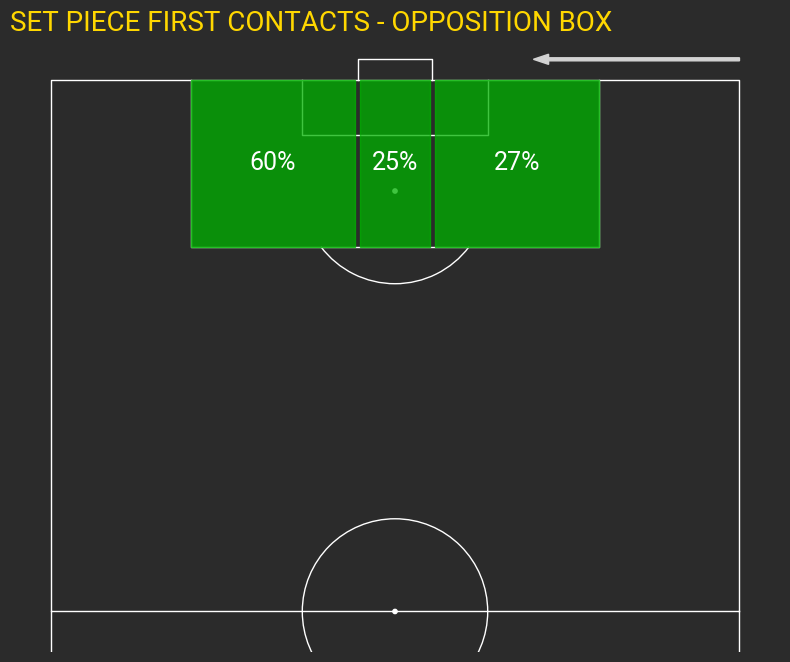

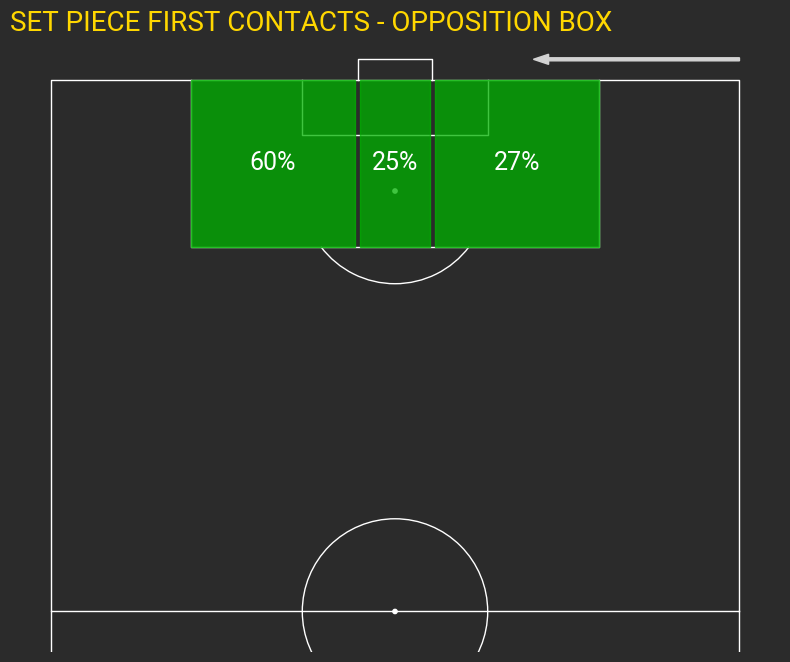

In [110]:
create_set_piece_first_contacts_plot(att_set_piece_chart)

Shot data extraction

In [111]:
df_shots = fetch_data(cursor, 'SELECT * FROM SHOT_EVENTS')

In [112]:
df_events.head()

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,COMPETITION,SEASON
0,f2ffde12,NaN,2,2257.5,2137.5,d48ad4ff,84603,56.175,57.855,39.848,45.696,1,1309,dribble,foot,ITA-Serie A,2324
1,0c234040,NaN,1,7.5,7.5,dc56fe14,101596,50.610,59.010,59.840,60.996,1,3,dribble,foot,ITA-Serie A,2324
2,604ceaa0,NaN,1,793.5,793.5,cf74a709,323450,44.835,47.355,47.532,50.592,1,238,dribble,foot,ITA-Serie A,2324
3,ff49299b,2.621506e+09,2,3173.0,3053.0,e2befd26,424820,62.370,64.365,52.972,47.940,1,1356,pass,head,ITA-Serie A,2324
4,9ca90d35,2.629326e+09,1,2751.0,2751.0,6a7ad59d,323240,43.995,43.995,46.036,46.036,0,608,interception,foot,ITA-Serie A,2324


In [113]:
df_shots = df_shots.merge(df_events[['MATCH_ID', 'ACTION_ID', 'TEAM_FBREF_ID']], on=['MATCH_ID', 'ACTION_ID'])

In [114]:
df_shots = df_shots.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [115]:
inds1 = df_shots[df_shots['SCA_1_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index
inds2 = df_shots[df_shots['SCA_2_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index

In [116]:
inds_union = np.union1d(inds1, inds2)

In [117]:
df_shots_set_piece = df_shots.loc[inds_union]

In [118]:
df_shots_set_piece = df_events[['MATCH_ID','ACTION_ID']].merge(df_shots_set_piece, on=['MATCH_ID', 'ACTION_ID'])

In [119]:
df_shots_set_piece.loc[:, 'OPPO_TEAM_ID'] = "NaN"

In [121]:
df_shots_set_piece = specify_oppo_team_id_to_events(df_shots_set_piece, df_matches)

In [122]:
df_shots_set_piece = df_shots_set_piece.merge(team_names_2, on="OPPO_TEAM_ID")

In [123]:
# df_shots_set_piece = df_shots_set_piece.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [124]:
df_shots_set_piece = df_shots_set_piece.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [125]:
df_shots = df_shots.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [126]:
df_shots = df_shots.merge(df_competitions, on=['COMPETITION', 'SEASON'])

In [127]:
df_last_5_matches = df_matches.copy()

In [128]:
df_last_5_matches = df_last_5_matches.merge(df_competitions, on=['COMPETITION', 'SEASON'])

In [129]:
home_teams = team_names.copy()
away_teams = team_names.copy()

In [130]:
home_teams.rename({'TEAM_FBREF_ID':'HOME_TEAM_ID', 'TEAM_NAME':'HOME_TEAM_NAME'}, axis=1, inplace=True)
away_teams.rename({'TEAM_FBREF_ID':'AWAY_TEAM_ID', 'TEAM_NAME':'AWAY_TEAM_NAME'}, axis=1, inplace=True)

In [131]:
df_last_5_matches = df_last_5_matches.merge(home_teams[['HOME_TEAM_NAME', 'HOME_TEAM_ID']], on=['HOME_TEAM_ID'])
df_last_5_matches = df_last_5_matches.merge(away_teams[['AWAY_TEAM_NAME', 'AWAY_TEAM_ID']], on=['AWAY_TEAM_ID'])

In [132]:
df_last_5_matches_filt = df_last_5_matches[df_last_5_matches['SEASON'] == season_selected]
df_last_5_matches_filt = df_last_5_matches_filt[df_last_5_matches_filt['COMPETITION_ACRONYM'] == league_selected]


In [133]:
team_selected = 'Arsenal'

In [134]:
df_shots = df_shots.merge(df_events[['MATCH_ID', 'ACTION_ID', 'PERIOD_ID','NEW_TIME_SECONDS','START_X','END_X','START_Y', 
                         'END_Y', 'PLAYER_WS_ID', 'RESULT_ID']], on=['MATCH_ID', 'ACTION_ID'])

In [235]:
df_shots = df_shots.merge(df_matches[['MATCH_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID', 'GAMEWEEK']], on='MATCH_ID', how='left')

In [238]:
df_shots['OPPO_TEAM_ID'] = df_shots.apply(lambda row: row['AWAY_TEAM_ID'] if row['TEAM_FBREF_ID'] == row['HOME_TEAM_ID'] else row['HOME_TEAM_ID'], axis=1)

In [239]:
df_shots.drop(['HOME_TEAM_ID', 'AWAY_TEAM_ID'], axis=1, inplace=True)

In [243]:
df_shots = df_shots.merge(team_names_2, on='OPPO_TEAM_ID')

In [273]:
df_shots = df_shots.merge(df_players[['PLAYER_WS_ID', 'PLAYER_FBREF_NAME']], on="PLAYER_WS_ID")

In [274]:
df_last_5_matches_filt = df_last_5_matches_filt[(df_last_5_matches_filt['HOME_TEAM_NAME'] == team_selected) | 
                                                (df_last_5_matches_filt['AWAY_TEAM_NAME'] == team_selected)]
df_last_5_matches_filt = df_last_5_matches_filt.sort_values(by='GAMEWEEK')[-5:]
last_5_matches = list(df_last_5_matches_filt['MATCH_ID'])
df_shots_last_5_matches = df_shots[df_shots['MATCH_ID'].isin(last_5_matches)]

In [275]:
df_shots_last_5_matches = df_shots_last_5_matches[df_shots_last_5_matches['TEAM_NAME'] == team_selected]

In [276]:
df_shots_last_5_matches

,MATCH_ID,ACTION_ID,XG,PSXG,OUTCOME,DISTANCE,BODY_PART,NOTES,SCA_1_PLAYER_WS_ID,SCA_1_PLAYER_FBREF_EVENT,SCA_2_PLAYER_WS_ID,SCA_2_PLAYER_FBREF_EVENT,TEAM_FBREF_ID,TEAM_NAME,COMPETITION,SEASON,COMPETITION_ACRONYM,PERIOD_ID,NEW_TIME_SECONDS,START_X,END_X,START_Y,END_Y,PLAYER_WS_ID,RESULT_ID,OPPO_TEAM_ID,OPPO_TEAM_NAME,GAMEWEEK,PLAYER_FBREF_NAME
1626,0e9002ec,1031,0.16,0.47,Saved,10,Left Foot,None,424462.0,Pass (Live),334087.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,2,1291.0,95.445,102.690,38.352,34.000,113994,0,cd051869,Brentford,28,Leandro Trossard
1671,0e9002ec,925,0.04,NaN,Blocked,16,Left Foot,Volley,367185.0,Pass (Live),322036.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,2,882.0,90.825,97.020,43.928,39.304,332325,0,cd051869,Brentford,28,Declan Rice
1690,0e9002ec,253,0.04,NaN,Blocked,20,Left Foot,None,247454.0,Pass (Live),367185.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,1,1035.0,86.415,88.200,29.784,30.192,326413,0,cd051869,Brentford,28,Kai Havertz
1699,0e9002ec,754,0.09,NaN,Off Target,22,Right Foot,None,367185.0,Pass (Live),332325.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,2,58.0,85.155,105.000,30.464,26.520,247454,0,cd051869,Brentford,28,Martin Ødegaard
1710,0e9002ec,795,0.03,NaN,Off Target,23,Left Foot,None,113994.0,Pass (Live),247454.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,2,179.0,84.000,105.000,42.704,33.932,367185,0,cd051869,Brentford,28,Bukayo Saka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100263,a1da23dc,154,0.12,0.05,Saved,5,Head,None,332325.0,Pass (Dead),367185.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,1,497.0,100.485,105.000,29.920,32.164,334087,0,7c21e445,West Ham,24,Gabriel Dos Santos
100267,a1da23dc,613,0.79,0.95,Goal,13,Left Foot,None,367185.0,Fouled,113994.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,1,2425.0,92.925,105.000,34.000,32.640,367185,1,7c21e445,West Ham,24,Bukayo Saka
100269,a1da23dc,525,0.25,0.32,Goal,4,Head,None,332325.0,Pass (Dead),326413.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,1,1901.0,101.640,105.000,32.096,34.068,361822,1,7c21e445,West Ham,24,William Saliba
100298,a1da23dc,1295,0.07,0.02,Saved,16,Right Foot,None,380706.0,Pass (Live),326413.0,Pass (Live),18bb7c10,Arsenal,ENG-Premier League,2324,EPL,2,1715.0,90.615,102.585,43.656,36.584,345845,0,7c21e445,West Ham,24,Eddie Nketiah


In [277]:
df_shots_last_5_matches['OUTCOME'].value_counts()

OUTCOME
Blocked       28
Off Target    28
Goal          21
Saved         19
Woodwork       2
Name: count, dtype: int64

In [278]:
df_shots_last_5_matches['norm_start_x'] = df_shots_last_5_matches['START_X'] / 120
df_shots_last_5_matches['norm_start_y'] = df_shots_last_5_matches['START_Y'] / 80

In [279]:
max_size = 5
min_size = 2

In [280]:
xg_scaled = (df_shots_last_5_matches['XG'] - df_shots_last_5_matches['XG'].min()) / (df_shots_last_5_matches['XG'].max() - df_shots_last_5_matches['XG'].min())
df_shots_last_5_matches['xG_size'] = xg_scaled * (max_size - min_size) + min_size

In [301]:
import plotly.graph_objects as go

# Load your DataFrame here
# df_shots_last_5_matches = pd.read_csv("your_data.csv")

# Example to scale and position your data points if necessary
# This step depends on the actual size and orientation of your "vertical_pitch.png"
# Let's assume START_X and START_Y are already scaled to fit the image dimensions

df_shots_last_5_matches['hover_text'] = (
    'Player: ' + df_shots_last_5_matches['PLAYER_FBREF_NAME'].astype(str) +
    '<br>GW: ' + df_shots_last_5_matches['GAMEWEEK'].astype(str) +
    '<br>Opponent: ' + df_shots_last_5_matches['OPPO_TEAM_NAME'] +
    '<br>Period: ' + df_shots_last_5_matches['PERIOD_ID'].astype(str) +
    '<br>Time: ' + (df_shots_last_5_matches['NEW_TIME_SECONDS']//60).astype(int).astype(str) +
    '<br>XG: ' + df_shots_last_5_matches['XG'].astype(str) +
    '<br>Body Part: ' + df_shots_last_5_matches['BODY_PART'].astype(str)
    
)

# Create a Plotly figure
fig = go.Figure()

# Add the pitch as a background image
fig.add_layout_image(
    dict(
        source="vertical_pitch.png",  # Path to your pitch background image
        xref="x",
        yref="y",
        x=-4.8,
        y=109,
        sizex=77.5,
        sizey=115,
        # sizing="stretch",
        opacity=1.0,
        layer="below")
)

# Define marker symbols in Plotly's format
plotly_symbols = {
    'Goal': 'circle',
    'Saved': 'circle',
    'Blocked': 'x',
    'Off Target': 'x',
    'Woodwork': 'hexagon'
}

# Add scatter plots for each outcome type
for outcome, df_group in df_shots_last_5_matches.groupby('OUTCOME'):
    fig.add_trace(go.Scatter(
        x=(df_group['START_Y'] - 68)*-1,  # Assuming START_Y is the horizontal axis in your pitch image
        y=df_group['START_X'],  # Assuming START_X is the vertical axis in your pitch image
        mode='markers',
        marker=dict(
            color=outcome_colors[outcome],
            symbol=plotly_symbols[outcome],
            size=df_group['xG_size']*5,  # Adjust size scaling factor as needed
            opacity=df_group['OUTCOME'].map(outcome_alpha)
        ),
        name=outcome,
        text=df_group['hover_text'],  # This will be displayed on hover
        hoverinfo='text+name'
    ))

# Set axes to match the background image
fig.update_xaxes(showgrid=False, range=[0, 68])
fig.update_yaxes(showgrid=False, range=[52.5, 110])

# Remove the plot background color
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)'
                  , width=1250,height=1100)

fig.show()


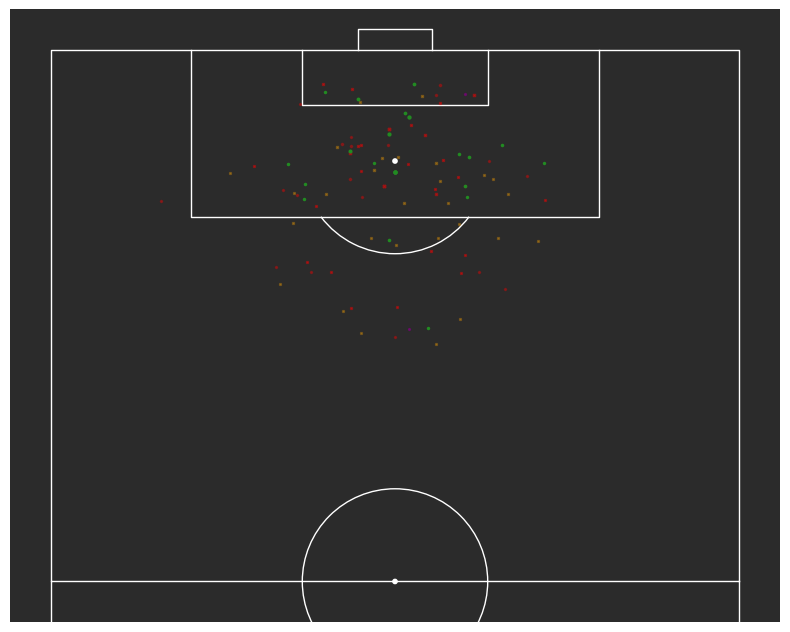

In [282]:
import mplcursors
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_shots_last_5_matches is your DataFrame
# Your existing code for setting up the pitch and plotting
pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
fig, ax = pitch.draw(figsize=(8, 10))

outcome_colors = {'Goal': 'forestgreen', 'Saved': 'red', 'Blocked': 'orange', 'Off Target': 'red', 
                  'Woodwork': 'purple'}
outcome_markers = {'Goal': 'o', 'Saved': 'o', 'Blocked': 'X', 'Off Target': 'X',  'Woodwork': 'h'}
outcome_alpha = {'Goal': 1., 'Saved': 0.3, 'Blocked': 0.3, 'Off Target': 0.4,  'Woodwork': 0.6}

scatter_plots = []

for i, row in df_shots_last_5_matches.iterrows():
    color = outcome_colors[row['OUTCOME']]
    marker = outcome_markers[row['OUTCOME']]
    alpha = outcome_alpha[row['OUTCOME']]
    # Plot and collect the scatter plot objects
    scatter_plot = ax.scatter(row['START_Y'], row['START_X'], s=row['xG_size'], c=color, marker=marker, alpha=alpha)
    scatter_plots.append(scatter_plot)

# Use mplcursors to add hover functionality
cursor = mplcursors.cursor(scatter_plots, hover=True)

@cursor.connect("add")
def on_add(sel):
    # Get the index of the selected point
    index = sel.target.index
    # Access the corresponding row in your dataframe
    row = df_shots_last_5_matches.iloc[index]
    # Set the annotation text to show the XG value
    sel.annotation.set_text(f'XG: {row["XG"]}')

plt.show()


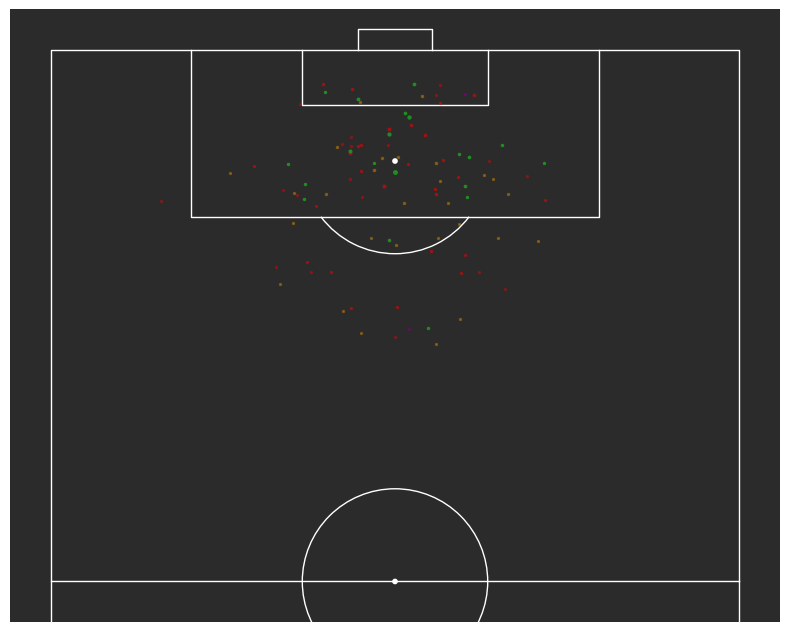

In [302]:
pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
fig, ax = pitch.draw(figsize=(8, 10))

outcome_colors = {'Goal': 'forestgreen', 'Saved': 'red', 'Blocked': 'orange', 'Off Target': 'red', 
                  'Woodwork': 'purple'}
outcome_markers = {'Goal': 'o', 'Saved': 'o', 'Blocked': 'X', 'Off Target': 'X',  'Woodwork': 'h'}
outcome_alpha = {'Goal': 1., 'Saved': 0.3, 'Blocked': 0.3, 'Off Target': 0.4,  'Woodwork': 0.6}

for i, row in df_shots_last_5_matches.iterrows():
    color = outcome_colors[row['OUTCOME']]
    marker = outcome_markers[row['OUTCOME']]
    alpha = outcome_alpha[row['OUTCOME']]
    ax.scatter(row['START_Y'], row['START_X'], s=row['xG_size'], c=color, marker=marker, alpha=alpha,
               label=f'Player: {row["PLAYER_WS_ID"]}, xG: {row["XG"]}')


In [139]:
df_shots['BODY_PART'].value_counts()

BODY_PART
Right Foot    62374
Left Foot     40572
Head          22293
Other           537
Name: count, dtype: int64

In [140]:
df_shots['NOTES'].value_counts()

NOTES
Volley                  15393
Free kick                4146
Deflected                2878
Deflected, Volley         270
Free kick, Deflected       86
nan                         6
Free kick, Volley           1
Name: count, dtype: int64

In [141]:
df_shots['OUTCOME'].value_counts()

OUTCOME
Off Target          46789
Blocked             33689
Saved               29258
Goal                13510
Woodwork             2402
Saved off Target      128
Name: count, dtype: int64

In [142]:
shots_xg_conceded_from_set_pieces_grouped = df_shots_set_piece[['OPPO_TEAM_NAME','COMPETITION','SEASON', 
                                                                'XG']].groupby(['OPPO_TEAM_NAME','COMPETITION','SEASON']).sum()

In [143]:
shots_xg_from_set_pieces_grouped = df_shots_set_piece[['TEAM_NAME','COMPETITION','SEASON', 
                                                    'XG']].groupby(['TEAM_NAME','COMPETITION','SEASON']).sum()

In [144]:
shots_xg_conceded_from_set_pieces_grouped = team_name_matches_played.merge(shots_xg_conceded_from_set_pieces_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [145]:
shots_xg_from_set_pieces_grouped = team_name_matches_played.merge(shots_xg_from_set_pieces_grouped.reset_index(),
                                                                  on=['TEAM_NAME','COMPETITION','SEASON'])

In [146]:
shots_xg_conceded_from_set_pieces_grouped['OPPOSITION XG FROM SET PIECE CROSSES PER GAME'] = shots_xg_conceded_from_set_pieces_grouped['XG'] / \
                                                                        shots_xg_conceded_from_set_pieces_grouped['MATCHES_PLAYED']

In [147]:
shots_xg_from_set_pieces_grouped['XG FROM SET PIECE CROSSES PER GAME'] = shots_xg_from_set_pieces_grouped['XG'] / \
                                                                        shots_xg_from_set_pieces_grouped['MATCHES_PLAYED']

In [148]:
# shots_xg_from_set_pieces_grouped
# shots_xg_conceded_from_set_pieces_grouped

In [149]:
df_goals_set_piece = df_shots_set_piece[df_shots_set_piece['OUTCOME'] == 'Goal']

In [150]:
df_goals_set_piece_chart = df_goals_set_piece.groupby(['TEAM_NAME','COMPETITION','SEASON']).count()['MATCH_ID']

In [151]:
df_goals_set_piece_chart = df_goals_set_piece_chart.reset_index()
df_goals_set_piece_chart = df_goals_set_piece_chart.rename({'MATCH_ID':'SET PIECE GOALS SCORED'}, axis= 1)

In [152]:
df_goals_set_piece_conc = df_goals_set_piece.groupby(['OPPO_TEAM_NAME','COMPETITION','SEASON']).count()['MATCH_ID']
df_goals_set_piece_conc = df_goals_set_piece_conc.reset_index()
df_goals_set_piece_conc = df_goals_set_piece_conc.rename({'MATCH_ID':'SET PIECE GOALS CONCEDED',
                                                            'OPPO_TEAM_NAME':'TEAM_NAME'}, axis= 1)

In [153]:
df_goals_set_piece_chart = df_goals_set_piece_chart.merge(df_goals_set_piece_conc, on=['TEAM_NAME', 'COMPETITION', 'SEASON'], how='outer')

In [154]:
df_goals_set_piece_chart = df_goals_set_piece_chart.fillna(0)

In [155]:
df_goals_set_piece_chart = df_goals_set_piece_chart.merge(team_names[['TEAM_NAME', 'TEAM_LOGO_URL']], on='TEAM_NAME')
df_goals_set_piece_chart = df_goals_set_piece_chart.merge(df_competitions, on=['COMPETITION', 'SEASON'])

In [156]:
create_table_query = """
CREATE TABLE IF NOT EXISTS GOALS_FROM_SET_PIECES (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    SET_PIECE_GOALS_SCORED FLOAT,
    SET_PIECE_GOALS_CONCEDED FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [157]:
cur.execute(create_table_query)

In [158]:
df_goals_set_piece_chart.columns = df_goals_set_piece_chart.columns.str.replace(" ", "_")

In [159]:
df_goals_set_piece_chart = df_goals_set_piece_chart.drop('COMPETITION', axis=1)

In [160]:
upsert_to_snowflake("GOALS_FROM_SET_PIECES", df_goals_set_piece_chart, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 292 rows processed.


In [161]:
df_goals_set_piece_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.GOALS_FROM_SET_PIECES')

In [162]:
df_goals_set_piece_chart.rename(columns={'SET_PIECE_GOALS_SCORED':'SET PIECE GOALS SCORED',
                                'SET_PIECE_GOALS_CONCEDED':'SET PIECE GOALS CONCEDED'}, inplace=True)

In [163]:
filt_df_goals_set_piece_chart = df_goals_set_piece_chart[df_goals_set_piece_chart['SEASON'] == season_selected]
filt_df_goals_set_piece_chart = filt_df_goals_set_piece_chart[filt_df_goals_set_piece_chart['COMPETITION_ACRONYM'] == league_selected]

In [164]:
create_FM_team_scatter_chart(filt_df_goals_set_piece_chart, 'GOALS FROM SET PIECES', "AC Milan", 
                             'SET PIECE GOALS CONCEDED', 'SET PIECE GOALS SCORED', 0.9, 0, 16, 0, 17, 
                                                        "Low no. of set piece goals<br>Low no. of set piece goals conceded", 
                                                        "Low no. of set piece goals<br>High no. of set piece goals conceded",
                                                        "High no. of set piece goals<br>Low no. of set piece goals conceded",
                                                        "High no. of set piece goals<br>High no. of set piece goals conceded",
                                                        "orange", "red", "green", "orange")
